# Project: Fire Histories for Hydrologic Modeling
### Name: Jennifer Kraft
### Notebook: AVIRIS 2018, Process and plot Carbon data

#### Pseudocode workflow:

In this notebook, we will be processing the AVIRIS-derived carbon data layer for the Fire Histories for Hydrologic Modeling (Watersheds and Biodiversity) project for the EA Applications course.

We will complete the following steps:

1. Import necessary modules and set working directory
2. Define data paths to carbon folder on the Hub, containing 10 tif files.
3. Define path to Russian River Watershed boundary shape file (*and Global Watershed file?)
4. Import shapefile(s) using geopandas
5. Test plot the shapes to confirm.
6. Define function to open and clean/crop bands
7. Define function to combine tifs (*end up not using)
8. Reproject boundary to crs ('EPSG:32610')
9. Define list of arrays, then populate list
10. Define tif ordering before merge (*still requires adjustment)
11. Use merge_arrays function from rioxarray.merge to mosaic tifs in specified order
12. Mask to replace all 0 values with nan
13. Plot histogram, check min and max values, look for outliers/anomalies
14. Plot merged arrays, define range to exclude outlier values (*may require adjustment)
15. Return to any previous steps requiring adjustment for clean final product

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from osgeo import gdal
import earthpy as et
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry  import box
from tifffile import imsave
from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
import earthpy.plot as ep
import rasterio
from rasterio.plot import show

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data',
                      'fire-histories'))

<AxesSubplot:>

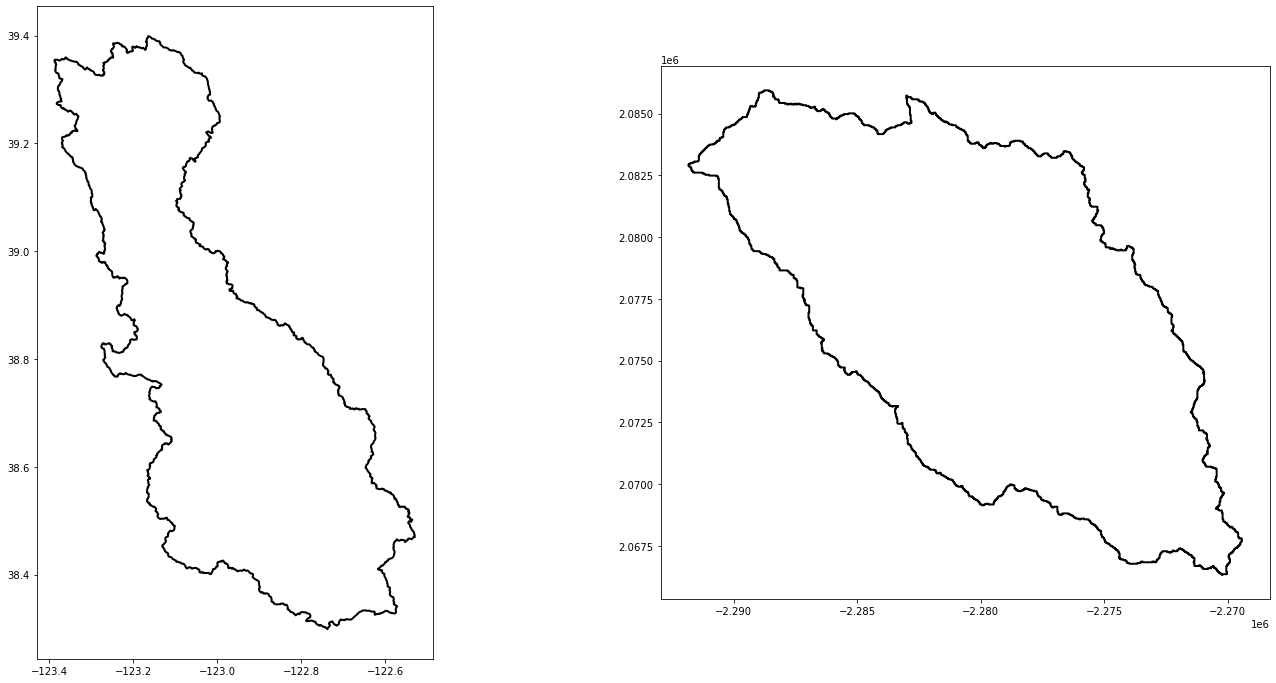

In [2]:
# data paths

carbon_path = os.path.join('carbon')


carbon_to_mosaic = glob.glob(os.path.join(str(carbon_path), "*.tif"))


# Define path to shape file of boundary crop
rr_watershed_boundary_path = os.path.join("boundaries",
                                          "shapefiles",
                                          "RR_HU8",
                                          "RR_HU8_polygon.shp")


# Import shapefile using geopandas
rr_watershed_boundary = gpd.read_file(rr_watershed_boundary_path)

# Define path to watershed shape file
gl_watershed_boundary_path = os.path.join("boundaries",
                                          "shapefiles",
                                          "GlobalWatershed",
                                          "GlobalWatershed.shp")


# Import shapefile using geopandas
gl_watershed_boundary = gpd.read_file(gl_watershed_boundary_path)

# Test shapes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

rr_watershed_boundary.plot(ax=ax1,
                           facecolor='none',
                           edgecolor='black',
                           linewidth=2,)

gl_watershed_boundary.plot(ax=ax2,
                           facecolor='none',
                           edgecolor='black',
                           linewidth=2,)




# Functions section

### rxr library

In [3]:

#Function for clipping to shp and opening with rioxarray 

def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    # YOUR CODE HERE

    """Open and clean a single landsat band .

    Parameters
    -----------
    band_path:string A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
    A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
     A tuple of min and max range of values for the data. Default = None

    Returns
    -----------
     band : xarray DataArray
        An xarray DataArray clipped to a crop boundary and masked if a range is given
    """

    crop_bound_box = [box(*crop_bound.bounds.loc[0])]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable, 
                                 parse_coordinates=False).rio.clip(crop_bound_box,
                                                             all_touched=True,
                                                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band


In [4]:
# Function to read in list of tifs into an xarray object

def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True)[1].squeeze())
        
        out_xr[i]["band"]=i+1
    (out_xr,) = xr.broadcast(*out_xr)
    
    return xr.concat(out_xr, dim="band") 



# **** START HERE:

In [5]:

#reproject boundary to crs
rr_watershed_boundary = rr_watershed_boundary.to_crs('EPSG:32610')

#Define list of carbon arrays, then populate list of arrays
carbon_tiles = []
for image in carbon_to_mosaic:
    tile = open_clean_bands(image, rr_watershed_boundary, valid_range=(0,1000),variable=None)
    carbon_tiles.append(tile)

#carbon_tiles    

In [6]:
#rxr_order2 = [0, 5, 6, 4, 7, 8, 1, 3, 9, 2]
rxr_order = [0, 1, 8, 2, 4, 9, 3, 5, 6, 7]
carbon_tiles_order2 = [carbon_tiles[i] for i in rxr_order]

In [7]:
# order 2
#rioxarray merge function call
merged_carbon_order2 = merge_arrays(carbon_tiles_order2, method='first') 

#merged_carbon_order2

In [8]:
#Mask to replace all 0 values with nan
mask = (merged_carbon_order2 == 0)
merged_carbon_mask2 = (merged_carbon_order2.where(~xr.where(mask, True,False)))
#merged_carbon_mask2

In [9]:
#Define extent
carbon_extent = plotting_extent(merged_carbon_mask2[1],merged_carbon_mask2.rio.transform())

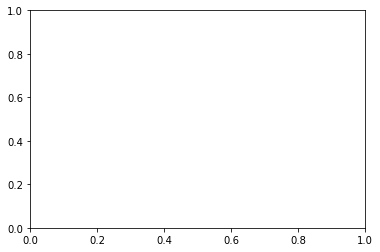

In [10]:
def plot_array(array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=spatial_extent,clim=colorlimit);
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap);
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca();
    ax.ticklabel_format(useOffset=False, style='plain');
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

In [11]:
merged_carbon_mask2[1,:,:].max()

<xarray.DataArray ()>
array(559.19244385)
Coordinates:
    band         int64 2
    spatial_ref  int64 0

TypeError: can only concatenate tuple (not "str") to tuple

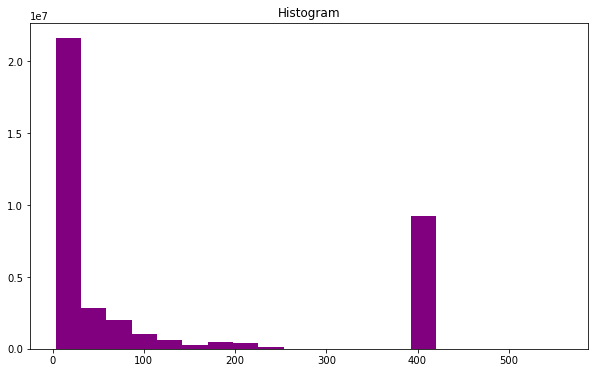

In [21]:
#Histogram
f, ax = plt.subplots(figsize=(10, 6))
merged_carbon_mask2[1].plot.hist(color="purple",
                      bins=20)
ax.set_title("Histogram of the Data")
plt.show()

<ipython-input-20-392221c828ca>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  current_cmap.set_bad(color='black')


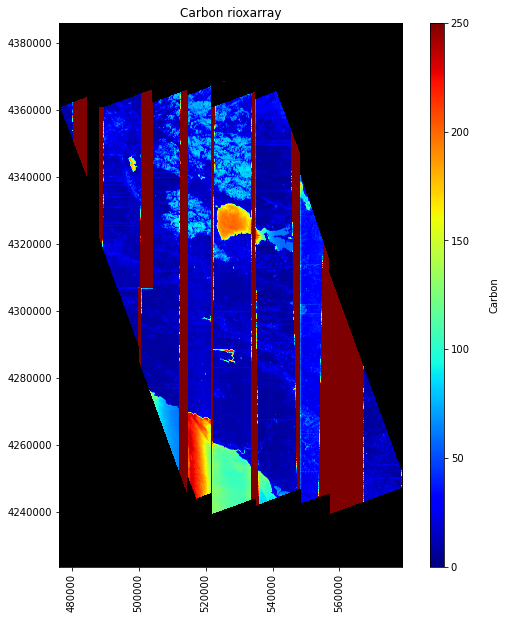

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
plot_array(merged_carbon_mask2[1,:,:],carbon_extent,(0,250),title='Carbon rioxarray',cmap_title='Carbon',
           colormap='jet')

current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='black')


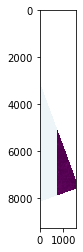

In [13]:
# Test opening and plotting one file at a time

# Define relative path to file
carbon_1_path = os.path.join("carbon",
                             "f180612t01p00r06_rfl_v1k2_img_PLSR_500_raw_coef_Carbon_400_2400.tif")

# Open first carbon file
carbon_1_data = rxr.open_rasterio(carbon_1_path, parse_coordinates=False)

carbon_1_data

# View object dimensions
carbon_1_data.shape

valid_range = (0,10000)
crop_bound_box = [box(*rr_watershed_boundary.bounds.loc[0])]
band = carbon_1_data.rio.clip(crop_bound_box,crs=rr_watershed_boundary.crs,all_touched=True,from_disk=True).squeeze()
mask = ((band < valid_range[0]) | (band > valid_range[1]))
band = band.where(~xr.where(mask, True, False))


#fig, ax = plt.subplots(figsize=(100, 100))
#plt.subplot(121)
plt.imshow(band[1], cmap=plt.cm.BuPu_r)
#plt.subplot(122)
#plt.imshow(carbon_1_data[1], extent=carbon_extent, cmap=plt.cm.BuPu_r)

#plt.show()
#plot_array(carbon_1_data[0],
#           carbon_extent,
#           (0, 10000),
#           title='carbon rioxarray',
#           cmap_title='carbon',
#           colormap='jet')


# set no data values to black

#current_cmap = plt.cm.get_cmap()
# current_cmap.set_bad(color='black')

In [14]:
carbon_paths_pre_path = os.path.join("carbon",
                                    "*.tif")

carbon_paths_pre = glob.glob(carbon_paths_pre_path)
carbon_paths_pre.sort()

carbon_pre = combine_tifs(carbon_paths_pre)

ep.plot_rgb(carbon_pre.values,
            rgb=[2, 1, 0],
            title="Carbon Composite Image")

plt.show()

<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre = combine_tifs(carbon_paths_pre)
<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre = combine_tifs(carbon_paths_pre)
<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre = combine_tifs(carbon_paths_pre)
<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre =

(42781, 1548)
(43047, 1745)
(42516, 1394)
(42742, 859)
(41083, 1454)
(41363, 1103)
(41146, 1026)


<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre = combine_tifs(carbon_paths_pre)
<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre = combine_tifs(carbon_paths_pre)
<ipython-input-14-bf16af94ec85>:7: RuntimeWarning: The file coordinates' transformation isn't rectilinear: xarray won't parse the coordinates in this case. Set `parse_coordinates=False` to suppress this warning.
  carbon_pre = combine_tifs(carbon_paths_pre)


(41447, 920)
(42262, 1431)
(33254, 1073)


ValueError: arguments without labels along dimension 'y' cannot be aligned because they have different dimension sizes: {33254, 43047, 41447, 41363, 42516, 42742, 42262, 41146, 41083, 42781}

### plotting

In [ ]:
# plotting function

def plot_array(array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

# Clipping section

### rxr library

In [ ]:
# prep shapefile for clipping 

# convert to crs of original raster

rr_hu8_boundary_crs = rr_watershed_boundary.to_crs('EPSG:32610')




In [ ]:
# run open_clean_bands function for clipping and cleaning carbon tifs (outputs a list of arrays)

carbon_tiles = []
for image, i in zip(carbon_to_mosaic, range(0,10)):
    tile = open_clean_bands(image,
                            rr_hu8_boundary_crs,
                            valid_range=(0,1000),
                            variable=None)
    carbon_tiles.append(tile)
carbon_tiles

# Merging Section

### rxr library

In [ ]:
# rearrange list of arrays from output of open_clean_bands

# order 1

rxr_order1 = [3, 0, 1, 2, 6, 7, 4, 8, 9, 5]

rxr_tiles_order1 = [carbon_tiles[i] for i in rxr_order1]

rxr_tiles_order1

# order 2

rxr_order2 = [0, 5, 6, 4, 7, 8, 1, 3, 9, 2]

rxr_tiles_order2 = [carbon_tiles[i] for i in rxr_order2]

rxr_tiles_order2

In [ ]:
# merge list of arrays for mosaic

# order 1

merged_carbon_order1 = merge_arrays(rxr_tiles_order1)

mask = (merged_carbon_order1 == 0)
merged_carbon_mask1 = (merged_carbon_order1.where(~xr.where(mask, True, False)))
    
    
# order2

merged_carbon_order2 = merge_arrays(rxr_tiles_order2)

mask = (merged_carbon_order2 == 0)
merged_carbon_mask2 = (merged_carbon_order2.where(~xr.where(mask, True, False)))

In [ ]:
# plot extent

carbon_extent = plotting_extent(merged_carbon_order1,
                                merged_carbon_order1.rio.transform())

In [ ]:
# file paths to rxr cropped rasters

carbon_clipped_path = os.path.join('carbon-outputs',
                                   'clipped')

carbon_clipped_to_mosaic = glob.glob(
    os.path.join(str(carbon_clipped_path), "*.tif"))

carbon_clipped_to_mosaic 

In [ ]:
# rearrange rxr clipped files

# order 1

order1 = [3, 1, 0, 2, 4, 7, 6, 8, 5, 9]

carbon_rxr_crop_to_mosaic_order1 = [carbon_clipped_to_mosaic[i] for i in order1]


string_carbon_rxr_crop_to_mosaic_order1 = " ".join(carbon_rxr_crop_to_mosaic_order1)

# order 2

order2 = [9, 5, 4 ,7, 8, 2, 3, 6, 1, 0]

carbon_rxr_crop_to_mosaic_order2 = [carbon_clipped_to_mosaic[i] for i in order2]


string_carbon_rxr_crop_to_mosaic_order2 = " ".join(carbon_rxr_crop_to_mosaic_order2)



# Plotting Section

## plot 1: rxr clipped and merged

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))


plot_array(merged_carbon_mask2[0, :, :],
           carbon_extent,
           (0, 50),
           title='carbon rioxarray',
           cmap_title='carbon',
           colormap='jet')


# set no data values to black

current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='black')